In [ ]:
!pip install -r requirements.txt -q

# Fine tuning Flan-T5 model on Spider dataset

## Dataset
Spider is a large-scale complex and cross-domain semantic parsing and text-to-SQL dataset annotated by 11 Yale students. The goal of the Spider challenge is to develop natural language interfaces to cross-domain databases. It consists of 10,181 questions and 5,693 unique complex SQL queries on 200 databases with multiple tables covering 138 different domains.

## Model

FLAN-T5 released with the Scaling Instruction-Finetuned Language Models paper is an enhanced version of T5 that has been finetuned in a mixture of tasks. The paper explores instruction finetuning with a particular focus on (1) scaling the number of tasks, (2) scaling the model size, and (3) finetuning on chain-of-thought data. The paper discovers that overall instruction finetuning is a general method for improving the performance and usability of pretrained language models.

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/flan2_architecture.jpg" alt="Flan t5 architecture" width="800"/>

Paper: https://arxiv.org/abs/2210.11416
Official repo: https://github.com/google-research/t5x


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
dataset = load_dataset("spider")

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['db_id', 'query', 'question', 'query_toks', 'query_toks_no_value', 'question_toks'],
        num_rows: 7000
    })
    validation: Dataset({
        features: ['db_id', 'query', 'question', 'query_toks', 'query_toks_no_value', 'question_toks'],
        num_rows: 1034
    })
})

In [ ]:
checkpoint = 'google/flan-t5-base'

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
class SpiderDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self.max_input_length = self.tokenizer.model_max_length
        self.max_target_length = self.tokenizer.model_max_length
        self.prefix = "translate English to SQL: "

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        question = data['question']
        query = data['query']
        input_ = f"{self.prefix} {question}"
        target = query
        input_ = self.tokenizer.encode_plus(input_, max_length=self.max_input_length, padding="max_length", truncation=True, return_tensors="pt")
        target = self.tokenizer.encode(target, max_length=self.max_target_length, padding="max_length", truncation=True, return_tensors="pt")
        return {
            "input_ids": input_["input_ids"].flatten(),
            "attention_mask": input_["attention_mask"].flatten(),
            "target_ids": target.flatten()
        }

In [ ]:
train_dataset = SpiderDataset(dataset['train'], tokenizer)
val_dataset = SpiderDataset(dataset['validation'], tokenizer)

In [ ]:
BATCH_SIZE = 8

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class FlanT5ForSQL2Text(torch.nn.Module):
    def __init__(self, checkpoint):
        super(FlanT5ForSQL2Text, self).__init__()
        self.model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

    def forward(self, input_ids, attention_mask, target_ids):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=target_ids,
            return_dict= True)
        return outputs

In [ ]:
model = FlanT5ForSQL2Text(checkpoint).to(device)

In [ ]:
EPOCHS = 3
LEARNING_RATE = 1e-5

train_losses = []
val_losses = []

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0.0
    for idx, data in enumerate(train_loader):
        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        target_ids = data["target_ids"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, target_ids)
        loss = criterion(outputs.logits.view(-1, outputs.logits.shape[-1]), target_ids.view(-1))
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

        if idx % 50 == 0:
            print(f"Epoch: {epoch}, Batch: {idx}, Train Loss: {loss.item()}")

    # Average train loss for the epoch
    train_losses.append(epoch_train_loss / len(train_loader))

    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        for idx, data in enumerate(val_loader):
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            target_ids = data["target_ids"].to(device)

            outputs = model(input_ids, attention_mask, target_ids)
            loss = criterion(outputs.logits.view(-1, outputs.logits.shape[-1]), target_ids.view(-1))
            epoch_val_loss += loss.item()

            if idx % 50 == 0:
                print(f"Epoch: {epoch}, Batch: {idx}, Val Loss: {loss.item()}")

    # Average validation loss for the epoch
    val_losses.append(epoch_val_loss / len(val_loader))

Epoch: 0, Batch: 0, Train Loss: 59.32259750366211
Epoch: 0, Batch: 50, Train Loss: 25.353900909423828
Epoch: 0, Batch: 100, Train Loss: 15.98155403137207
Epoch: 0, Batch: 150, Train Loss: 5.011784076690674
Epoch: 0, Batch: 200, Train Loss: 4.622506141662598
Epoch: 0, Batch: 250, Train Loss: 4.248861789703369
Epoch: 0, Batch: 300, Train Loss: 3.9407763481140137
Epoch: 0, Batch: 350, Train Loss: 3.3389651775360107
Epoch: 0, Batch: 400, Train Loss: 2.7384355068206787
Epoch: 0, Batch: 450, Train Loss: 1.6997615098953247
Epoch: 0, Batch: 500, Train Loss: 1.0612488985061646
Epoch: 0, Batch: 550, Train Loss: 0.8007772564888
Epoch: 0, Batch: 600, Train Loss: 0.6365049481391907
Epoch: 0, Batch: 650, Train Loss: 0.6577104330062866
Epoch: 0, Batch: 700, Train Loss: 0.48192569613456726
Epoch: 0, Batch: 750, Train Loss: 0.4981831908226013
Epoch: 0, Batch: 800, Train Loss: 0.3830350339412689
Epoch: 0, Batch: 850, Train Loss: 0.4027935862541199
Epoch: 0, Batch: 0, Val Loss: 0.1638098508119583
Epoch: 

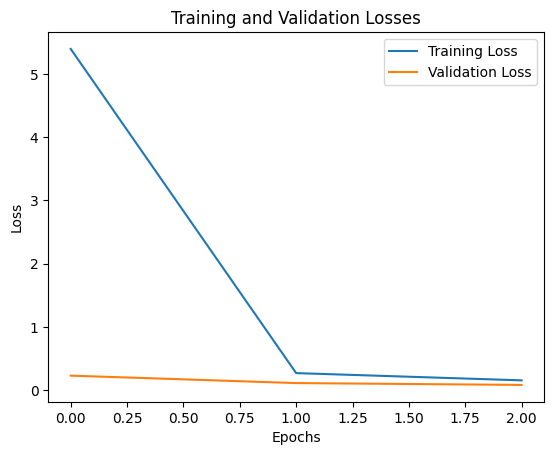

In [ ]:
# Plotting the losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [ ]:
# Saving model
torch.save(model.state_dict(), "flan_t5_base_spider_sql2text.pth")

# loading model from .pth file
model = FlanT5ForSQL2Text(checkpoint)
model.load_state_dict(torch.load("flan_t5_base_spider_sql2text.pth"))

<All keys matched successfully>

In [ ]:
# Testing model with human written question

def translate_to_sql(question, model, tokenizer, device):
    model.eval()
    input_ = f"translate English to SQL: {question}"
    input_ = tokenizer.encode_plus(input_, padding="max_length", truncation=True, return_tensors="pt")
    outputs = model.model.generate(input_ids=input_["input_ids"], attention_mask=input_["attention_mask"])
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

question = "How many heads of the departments are older than 56 ?	"

translate_to_sql(question, model, tokenizer, device)

'SELECT count(*) FROM departments AS t1 JOIN departments AS '